In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)
        plt.xticks(rotation=45)

    plt.show()

In [4]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [5]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [6]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_columns = 0, skiped_rows = 0):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)       
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

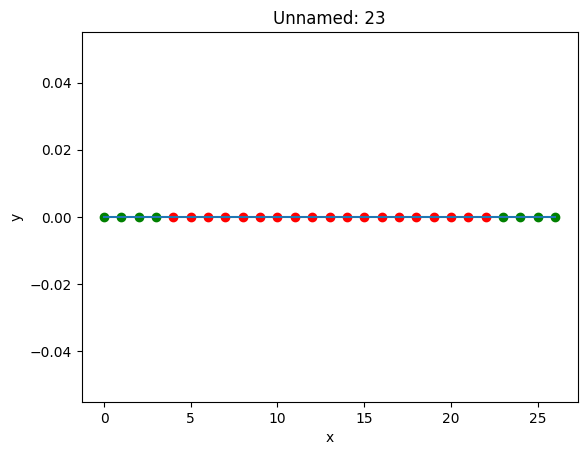

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1992,6.975029,6.959426,6.852734,6.678549,6.706535,6.650798,6.68561,6.621487,6.596499,6.594012,...,6.722392,6.747123,6.731621,6.677372,6.649445,6.647624,6.70292,6.793371,6.761593,6.671719
1993,7.132094,7.046355,6.832041,6.491279,6.424126,6.377567,6.416167,6.30286,6.311191,6.329279,...,6.532749,6.575627,6.522467,6.479551,6.450995,6.470904,6.53088,6.648755,6.504258,6.429653
1995,7.129371,7.060923,7.03453,6.876117,6.646807,6.616699,6.649321,6.590638,6.648993,6.631047,...,7.074841,7.101163,7.085956,7.077291,7.055727,6.808611,6.84103,6.959485,6.926932,6.877806
1996,7.592697,7.616436,7.54271,7.42147,7.417519,7.376503,7.427694,7.224639,7.241678,7.210073,...,7.442065,7.49159,7.450772,7.486106,7.555006,7.349858,7.368342,7.476438,7.401887,7.327211
1997,7.933796,7.998014,8.024012,7.760772,7.643309,7.616531,7.635378,7.53835,7.560788,7.571995,...,7.688084,7.696863,7.633471,7.542552,7.579275,7.722753,7.712655,7.813382,7.828251,7.7123
1998,9.053578,9.216113,9.00362,8.652579,8.582716,8.577108,8.625977,8.491367,8.533147,8.530636,...,8.746401,8.758135,8.676971,8.698,8.777832,8.824776,8.831843,8.877812,8.773445,8.596219
1999,10.233813,10.261377,9.940246,9.592619,9.382028,9.362019,9.436312,9.221804,9.237366,9.228097,...,9.470297,9.452949,9.377783,9.344825,9.341845,9.410147,9.44593,9.494895,9.439484,9.267383
2001,9.855196,9.966485,9.777215,9.743625,9.398654,9.354019,9.404792,9.208753,9.175989,9.200715,...,9.292425,9.322635,9.206431,9.211702,9.218662,9.231927,9.291336,9.469016,9.328222,9.217756
2002,9.261683,9.463089,9.446574,9.31622,8.900545,8.832586,8.831673,8.632277,8.55695,8.61818,...,8.670551,8.706332,8.595003,8.644607,8.710007,8.814119,8.855075,8.998215,8.911544,8.77317


In [7]:
df_2014 = read_csv_replace_missing_by_polynomial('desemprego_ipeadata.csv', 2, 1)
df_2014 = df_2014.iloc[:, 2:-1]
df_2014 = df_2014.T
header = df_2014.iloc[0]
df_2014 = df_2014[1:]
df_2014.columns = header
df_2014 = df_2014.rename_axis('Ano')
df_2014

In [8]:
df = pd.read_csv('desemprego_pos_2012.csv')

df_transposed = df.transpose()
df_transposed
new_header = df_transposed.iloc[0]
df_transposed = df_transposed[1:]
df_transposed.columns = new_header
df_transposed = df_transposed.rename_axis('Ano')
df_transposed

Estado,Acre,Rondônia,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,...,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
Ano,,,,,,,,,,,,,,,,,,,,,
2012,9.2,8.1,11.1,8.5,8.0,12.6,8.4,7.9,7.7,7.3,...,7.6,8.6,7.8,5.6,4.1,5.3,7.6,6.6,6.3,8.8
2012.1,9.0,6.3,9.1,5.9,7.9,14.7,7.8,9.2,7.1,8.2,...,7.3,7.5,7.5,5.3,3.8,5.1,7.1,5.8,5.3,8.5
2012.2,7.8,5.9,9.5,7.5,7.2,14.2,7.3,7.7,6.2,8.1,...,6.9,7.5,7.0,4.7,3.2,4.7,5.0,5.2,5.0,8.7
2012.3,8.2,5.2,8.3,8.4,6.9,12.1,7.7,7.6,7.0,7.6,...,6.7,6.9,6.8,4.5,2.7,4.4,5.0,4.8,5.1,8.9
2013,10.9,6.2,10.4,8.9,7.9,11.5,9.3,9.5,8.4,8.9,...,7.8,7.3,7.8,4.9,3.7,5.4,4.8,5.8,6.8,9.7
2013.1,9.6,4.9,10.3,8.6,7.7,14.5,8.3,9.4,7.5,8.5,...,7.7,7.0,7.5,4.6,3.5,4.6,5.0,4.5,5.8,9.2
2013.2,8.9,4.6,8.4,8.0,7.8,11.0,6.2,7.5,7.5,7.3,...,7.2,6.9,7.4,4.3,2.8,4.9,4.4,3.9,5.2,9.0
2013.3,7.0,5.0,7.7,6.8,6.1,9.2,6.5,5.6,7.0,6.9,...,5.9,6.2,6.6,3.8,2.6,4.7,4.5,3.8,3.9,8.5
2014,8.1,5.0,8.3,7.7,7.8,11.4,8.6,6.4,7.1,7.9,...,6.4,6.8,7.3,4.2,3.1,5.4,4.7,4.5,5.7,9.1


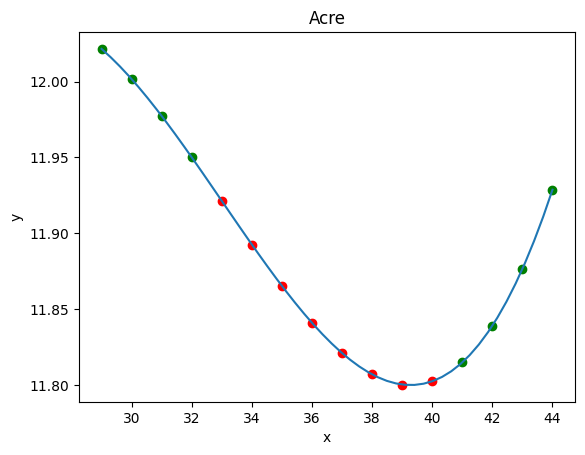

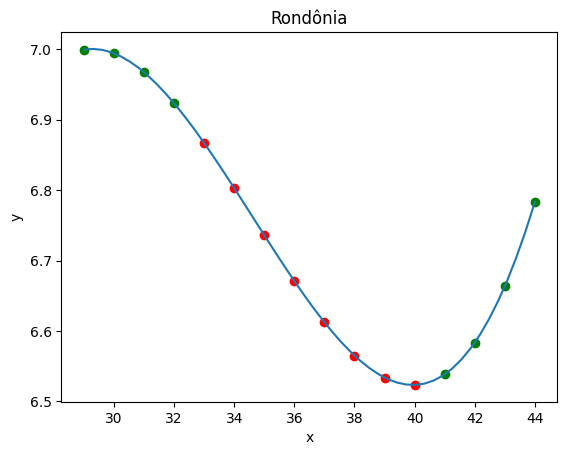

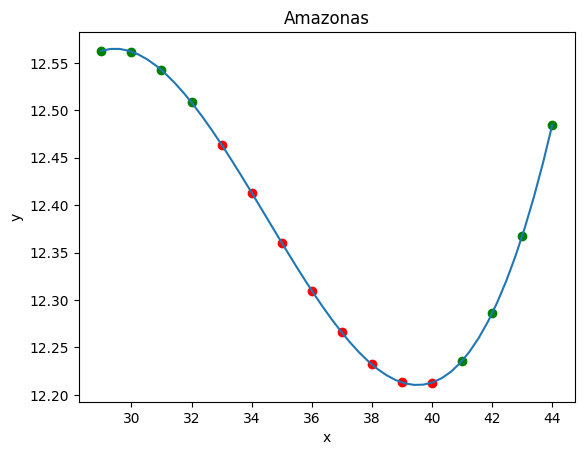

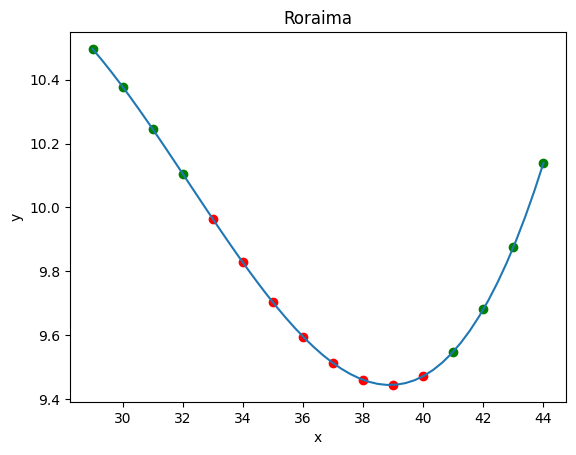

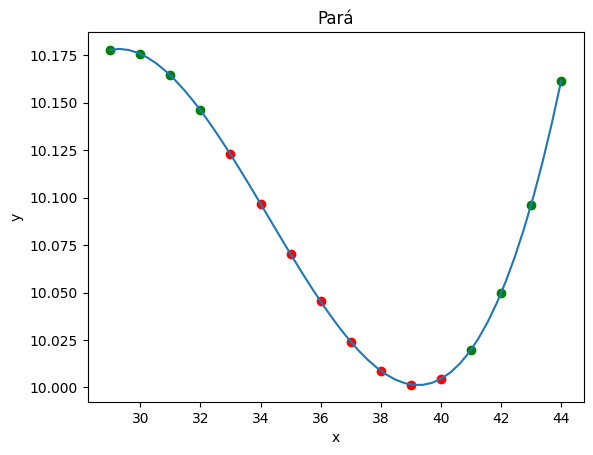

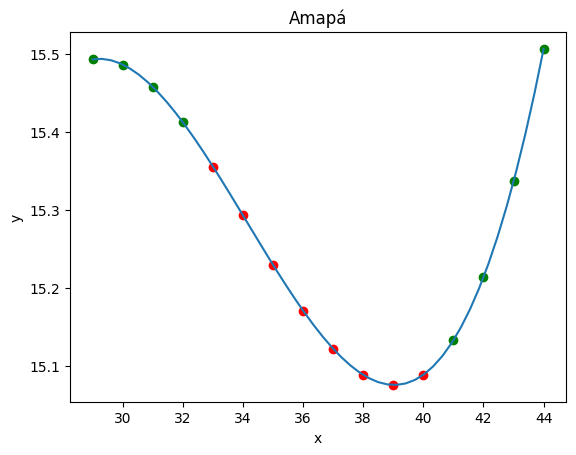

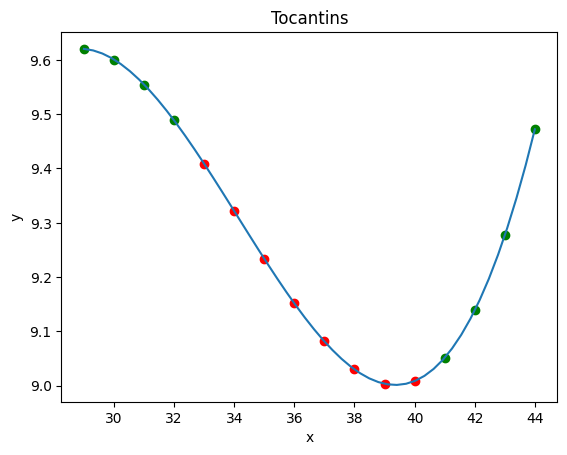

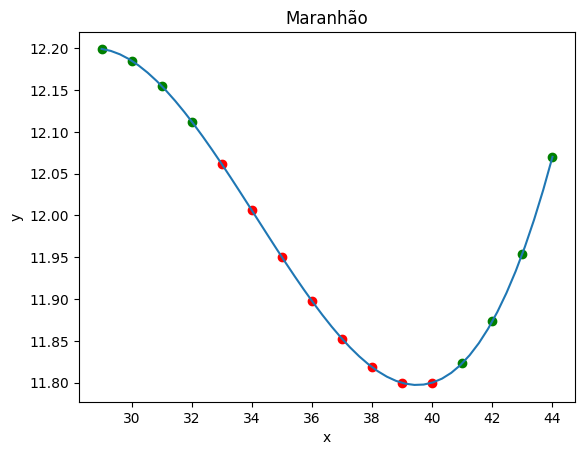

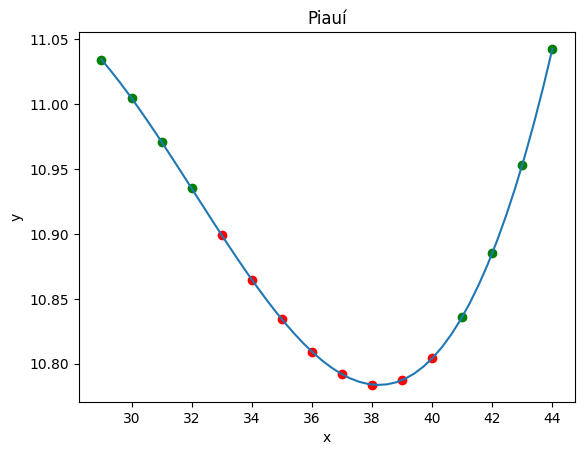

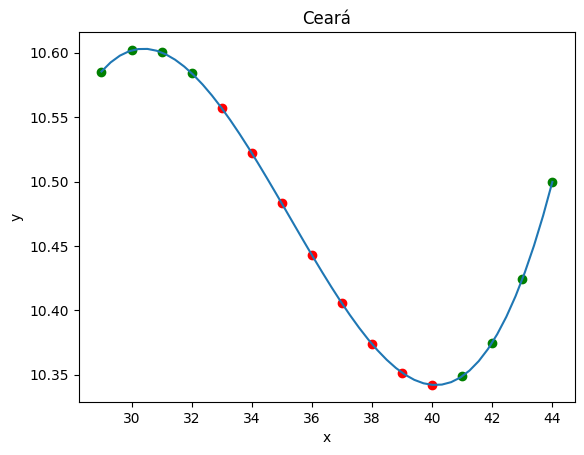

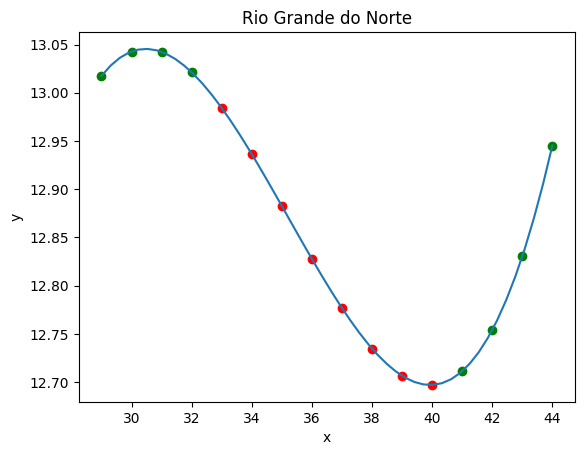

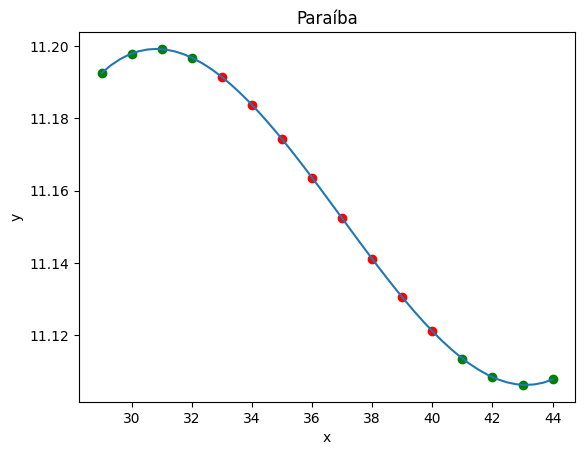

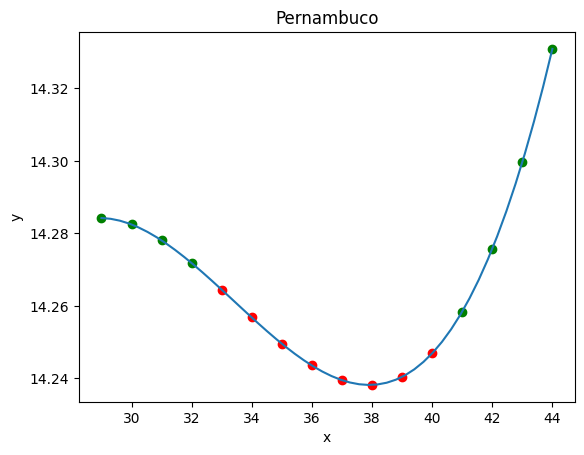

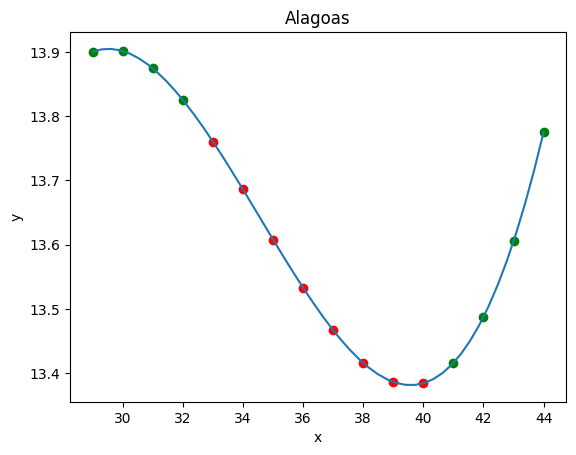

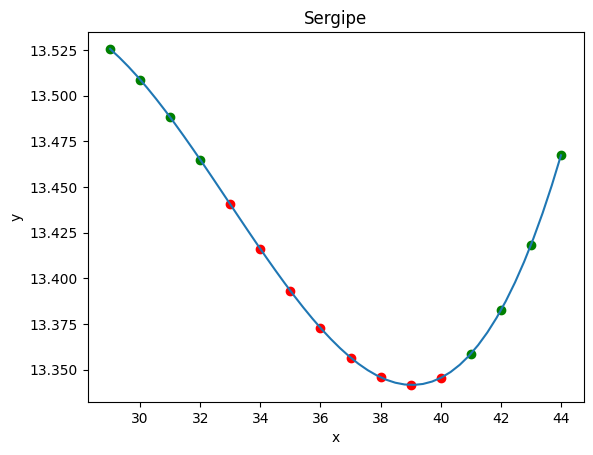

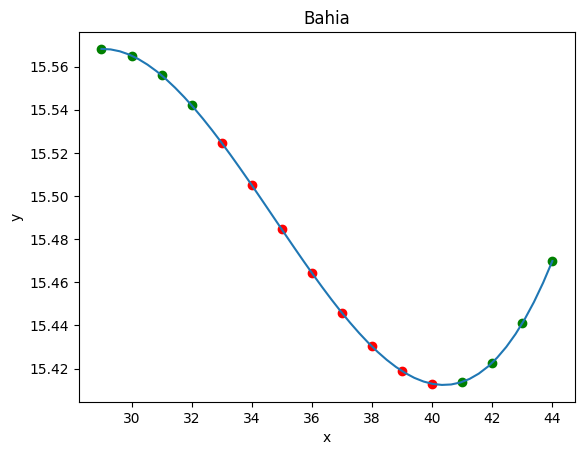

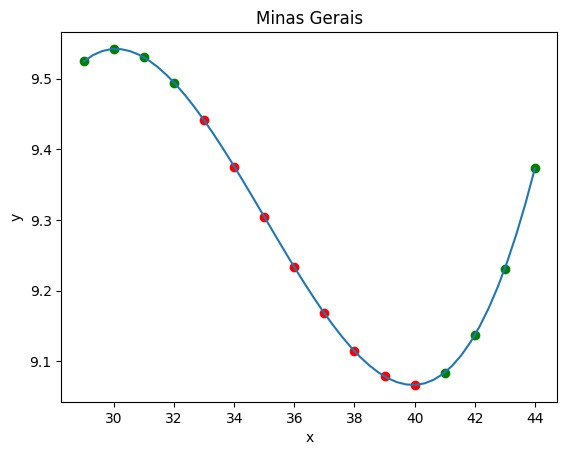

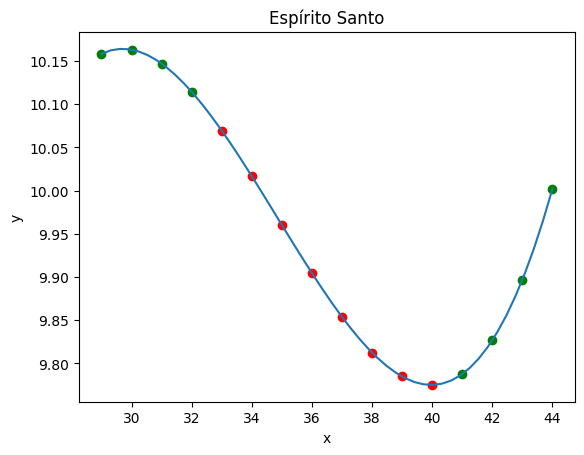

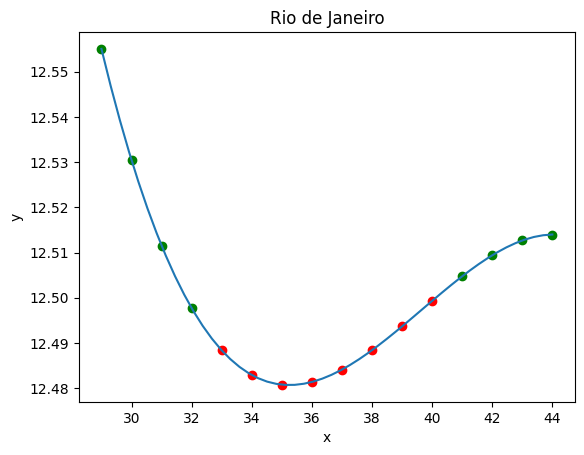

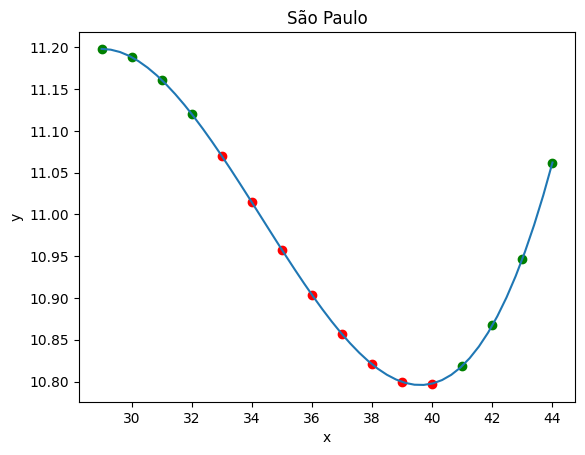

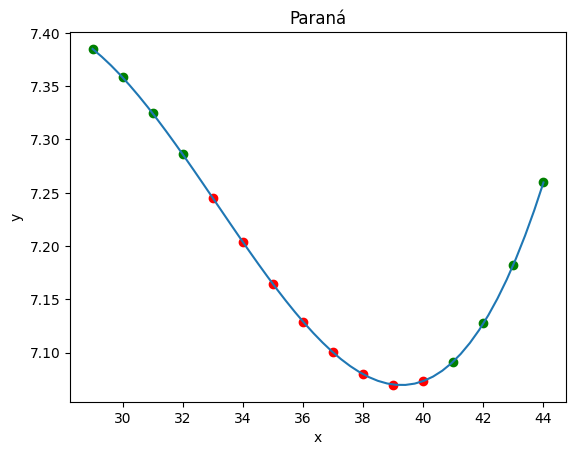

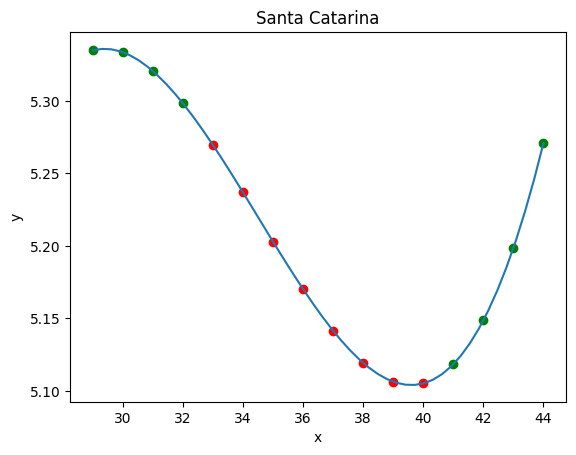

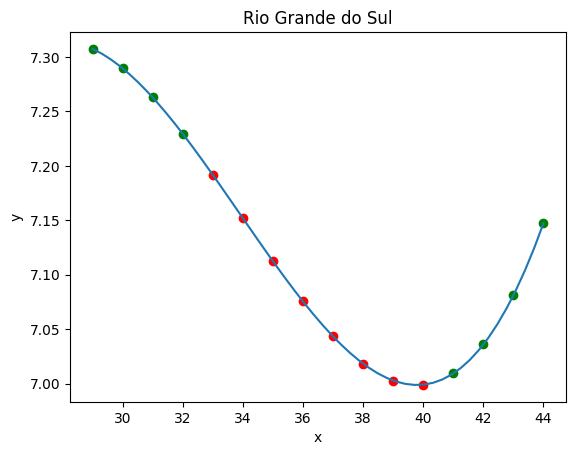

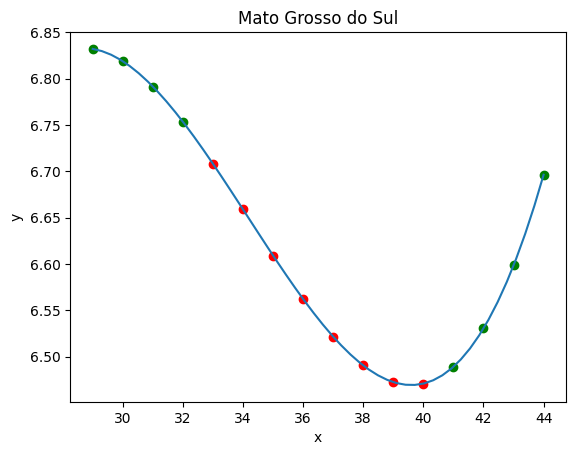

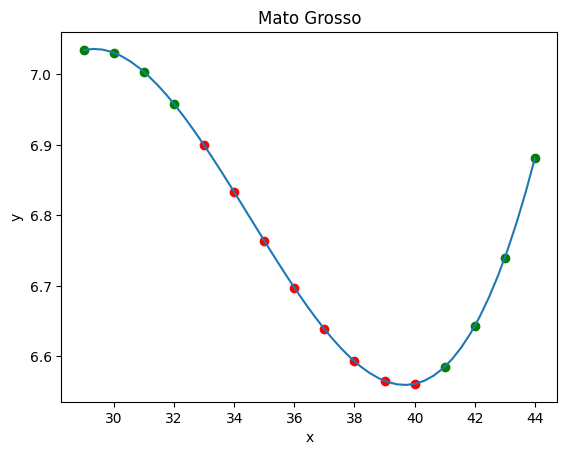

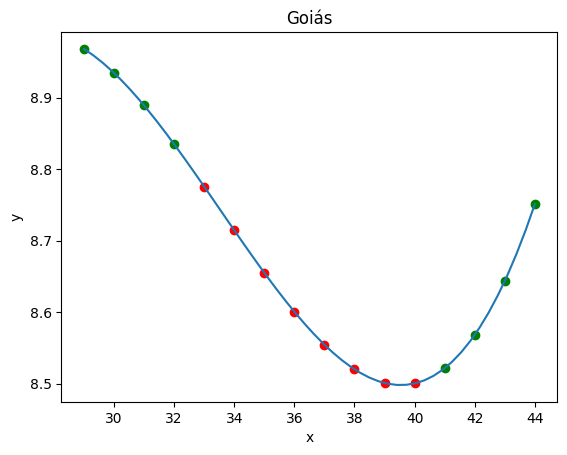

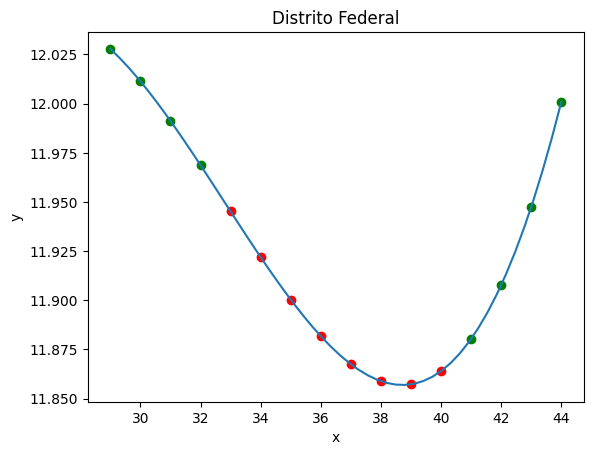

,Ano,Acre,Rondônia,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,...,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
0,2012.0,10.076000,6.464000,11.108000,8.360000,9.188000,13.740000,9.232000,9.964000,8.776000,...,9.156000,9.492000,9.728000,6.280000,4.616000,6.440000,6.336000,6.604000,7.596000,10.556000
1,2012.1,10.249077,6.471692,11.231077,8.479231,9.314923,14.086154,9.347385,10.217846,8.999077,...,9.332923,9.757385,9.958769,6.414615,4.712154,6.559231,6.339846,6.680923,7.719077,10.690615
2,2012.2,10.408336,6.567989,11.382929,8.764416,9.429738,14.223191,9.425162,10.395624,9.199077,...,9.484775,10.024051,10.173584,6.540541,4.801043,6.677749,6.347254,6.717960,7.856114,10.842467
3,2012.3,10.604765,6.682274,11.565072,9.003702,9.540452,14.423191,9.539448,10.631338,9.420505,...,9.609775,10.291908,10.373584,6.654827,4.911757,6.777749,6.418682,6.778674,7.973971,10.963896
4,2013.0,10.953041,6.816757,11.830589,9.238184,9.702521,14.705950,9.704965,10.938235,9.627402,...,9.802878,10.585012,10.608067,6.809999,5.070378,6.901887,6.573855,6.930399,8.170523,11.146654
5,2013.1,11.049707,6.840090,11.950589,9.444851,9.815854,14.892616,9.778299,11.114901,9.780735,...,9.909545,10.851679,10.778067,6.949999,5.150378,6.998554,6.693855,7.013732,8.297189,11.283321
6,2013.2,11.165836,6.949768,12.053815,9.651303,9.931984,14.970036,9.855718,11.276192,9.954929,...,10.006319,11.096840,10.926454,7.095161,5.224571,7.137264,6.780951,7.126635,8.461706,11.412353
7,2013.3,11.322086,7.062268,12.200690,9.870053,9.978859,15.120036,9.952593,11.429317,10.136179,...,10.106319,11.312465,11.057704,7.192036,5.305821,7.212264,6.852826,7.204760,8.630456,11.524853
8,2014.0,11.525117,7.168328,12.409781,10.170053,10.121283,15.365490,10.104108,11.753559,10.351330,...,10.269956,11.570041,11.230431,7.319308,5.399761,7.327415,6.955857,7.350215,8.860759,11.679399
9,2014.1,11.628908,7.234035,12.534319,10.244903,10.191625,15.485656,10.149687,11.915788,10.449856,...,10.387227,11.714587,11.349535,7.413833,5.469450,7.385822,7.024216,7.436585,8.956539,11.757562


In [9]:
df = read_csv_replace_missing_by_polynomial('desemprego_proc_pos_2012.csv', 0, 0)
df

In [10]:
df_ano = df.copy()
df_ano = df_ano.set_index('Ano')

df_ano.index = df_ano.index.astype(str).str.split('.').str[0]
df_avg = df_ano.groupby(['Ano']).mean()
df_avg

,Acre,Rondônia,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,...,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
Ano,,,,,,,,,,,,,,,,,,,,,
2012,10.334544,6.546489,11.321769,8.651837,9.368278,14.118134,9.385999,10.302202,9.098665,9.818854,...,9.395868,9.891336,10.058484,6.472496,4.760238,6.613682,6.360445,6.695389,7.786290,10.763245
2013,11.122668,6.917221,12.008921,9.551098,9.857304,14.922159,9.822894,11.189661,9.874811,10.221864,...,9.956265,10.961499,10.842573,7.011799,5.187787,7.062492,6.725372,7.068881,8.389968,11.341796
2014,11.666939,7.287260,12.610217,10.328300,10.244256,15.577783,10.192991,11.986521,10.508945,10.652422,...,10.450155,11.800434,11.415800,7.462443,5.511795,7.423718,7.077333,7.495401,9.015756,11.799788
2015,12.139670,7.654493,13.139356,10.723767,10.537304,16.255907,10.501090,12.529442,10.965401,11.020421,...,10.942052,12.471375,11.865646,7.813261,5.792915,7.683986,7.357560,7.838256,9.398111,12.093705
2016,12.458072,7.643673,13.263561,10.764101,10.587975,16.439693,10.392740,12.762358,11.203809,11.073199,...,10.979229,12.865739,11.874466,7.840669,5.798844,7.674279,7.332914,7.730867,9.378450,12.238790
2017,12.245790,7.282097,12.821072,10.533542,10.306831,16.090418,9.894472,12.460135,11.173036,10.712887,...,10.448735,12.728617,11.486716,7.553100,5.526597,7.404242,7.012814,7.251143,8.980786,12.085632
2018,12.148886,7.152179,12.662274,10.642202,10.211085,15.812868,9.761228,12.318837,11.037275,10.581166,...,10.241458,12.577126,11.319293,7.440077,5.417481,7.324869,6.911971,7.109465,8.919908,12.018938
2019,12.045733,7.004255,12.576164,10.430272,10.177874,15.509234,9.617662,12.204421,11.015949,10.594941,...,10.168769,12.544345,11.198876,7.368470,5.342752,7.291978,6.834977,7.037991,8.947167,12.023662
2020,11.905311,6.830604,12.440277,9.898626,10.115271,15.329624,9.371493,12.039300,10.881622,10.540017,...,10.043678,12.488461,11.044481,7.229325,5.254689,7.174483,6.687177,6.871142,8.745410,11.936222


In [11]:
df_until_2012 = df_2014.copy()
df_until_2012 = df_until_2012.iloc[:-3]
df_until_2012

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1992,6.975029,6.959426,6.852734,6.678549,6.706535,6.650798,6.68561,6.621487,6.596499,6.594012,...,6.722392,6.747123,6.731621,6.677372,6.649445,6.647624,6.70292,6.793371,6.761593,6.671719
1993,7.132094,7.046355,6.832041,6.491279,6.424126,6.377567,6.416167,6.30286,6.311191,6.329279,...,6.532749,6.575627,6.522467,6.479551,6.450995,6.470904,6.53088,6.648755,6.504258,6.429653
1995,7.129371,7.060923,7.03453,6.876117,6.646807,6.616699,6.649321,6.590638,6.648993,6.631047,...,7.074841,7.101163,7.085956,7.077291,7.055727,6.808611,6.84103,6.959485,6.926932,6.877806
1996,7.592697,7.616436,7.54271,7.42147,7.417519,7.376503,7.427694,7.224639,7.241678,7.210073,...,7.442065,7.49159,7.450772,7.486106,7.555006,7.349858,7.368342,7.476438,7.401887,7.327211
1997,7.933796,7.998014,8.024012,7.760772,7.643309,7.616531,7.635378,7.53835,7.560788,7.571995,...,7.688084,7.696863,7.633471,7.542552,7.579275,7.722753,7.712655,7.813382,7.828251,7.7123
1998,9.053578,9.216113,9.00362,8.652579,8.582716,8.577108,8.625977,8.491367,8.533147,8.530636,...,8.746401,8.758135,8.676971,8.698,8.777832,8.824776,8.831843,8.877812,8.773445,8.596219
1999,10.233813,10.261377,9.940246,9.592619,9.382028,9.362019,9.436312,9.221804,9.237366,9.228097,...,9.470297,9.452949,9.377783,9.344825,9.341845,9.410147,9.44593,9.494895,9.439484,9.267383
2001,9.855196,9.966485,9.777215,9.743625,9.398654,9.354019,9.404792,9.208753,9.175989,9.200715,...,9.292425,9.322635,9.206431,9.211702,9.218662,9.231927,9.291336,9.469016,9.328222,9.217756
2002,9.261683,9.463089,9.446574,9.31622,8.900545,8.832586,8.831673,8.632277,8.55695,8.61818,...,8.670551,8.706332,8.595003,8.644607,8.710007,8.814119,8.855075,8.998215,8.911544,8.77317


In [12]:
df_appended = df_until_2012.append(df_avg)
df_appended.columns = df_appended.columns + " - Desemprego"
df_appended.to_csv('desemprego_processado.csv', index=True)
df_appended

,Acre - Desemprego,Alagoas - Desemprego,Amazonas - Desemprego,Amapá - Desemprego,Bahia - Desemprego,Ceará - Desemprego,Distrito Federal - Desemprego,Espírito Santo - Desemprego,Goiás - Desemprego,Maranhão - Desemprego,...,Paraná - Desemprego,Rio de Janeiro - Desemprego,Rio Grande do Norte - Desemprego,Rondônia - Desemprego,Roraima - Desemprego,Rio Grande do Sul - Desemprego,Santa Catarina - Desemprego,Sergipe - Desemprego,São Paulo - Desemprego,Tocantins - Desemprego
Ano,,,,,,,,,,,,,,,,,,,,,
1992,6.975029,6.959426,6.852734,6.678549,6.706535,6.650798,6.68561,6.621487,6.596499,6.594012,...,6.722392,6.747123,6.731621,6.677372,6.649445,6.647624,6.70292,6.793371,6.761593,6.671719
1993,7.132094,7.046355,6.832041,6.491279,6.424126,6.377567,6.416167,6.30286,6.311191,6.329279,...,6.532749,6.575627,6.522467,6.479551,6.450995,6.470904,6.53088,6.648755,6.504258,6.429653
1995,7.129371,7.060923,7.03453,6.876117,6.646807,6.616699,6.649321,6.590638,6.648993,6.631047,...,7.074841,7.101163,7.085956,7.077291,7.055727,6.808611,6.84103,6.959485,6.926932,6.877806
1996,7.592697,7.616436,7.54271,7.42147,7.417519,7.376503,7.427694,7.224639,7.241678,7.210073,...,7.442065,7.49159,7.450772,7.486106,7.555006,7.349858,7.368342,7.476438,7.401887,7.327211
1997,7.933796,7.998014,8.024012,7.760772,7.643309,7.616531,7.635378,7.53835,7.560788,7.571995,...,7.688084,7.696863,7.633471,7.542552,7.579275,7.722753,7.712655,7.813382,7.828251,7.7123
1998,9.053578,9.216113,9.00362,8.652579,8.582716,8.577108,8.625977,8.491367,8.533147,8.530636,...,8.746401,8.758135,8.676971,8.698,8.777832,8.824776,8.831843,8.877812,8.773445,8.596219
1999,10.233813,10.261377,9.940246,9.592619,9.382028,9.362019,9.436312,9.221804,9.237366,9.228097,...,9.470297,9.452949,9.377783,9.344825,9.341845,9.410147,9.44593,9.494895,9.439484,9.267383
2001,9.855196,9.966485,9.777215,9.743625,9.398654,9.354019,9.404792,9.208753,9.175989,9.200715,...,9.292425,9.322635,9.206431,9.211702,9.218662,9.231927,9.291336,9.469016,9.328222,9.217756
2002,9.261683,9.463089,9.446574,9.31622,8.900545,8.832586,8.831673,8.632277,8.55695,8.61818,...,8.670551,8.706332,8.595003,8.644607,8.710007,8.814119,8.855075,8.998215,8.911544,8.77317


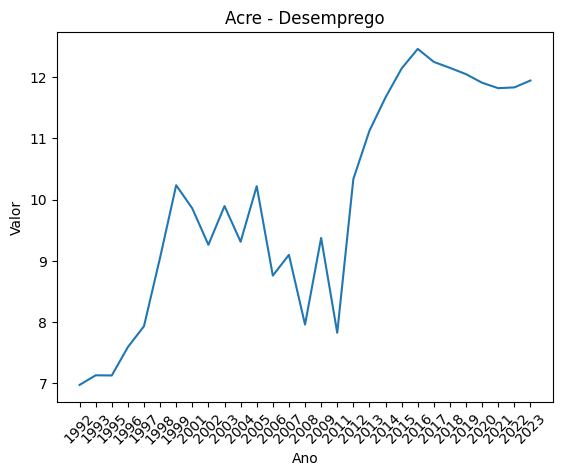

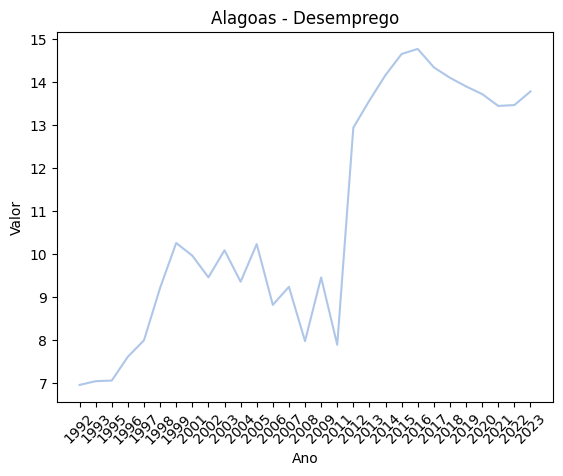

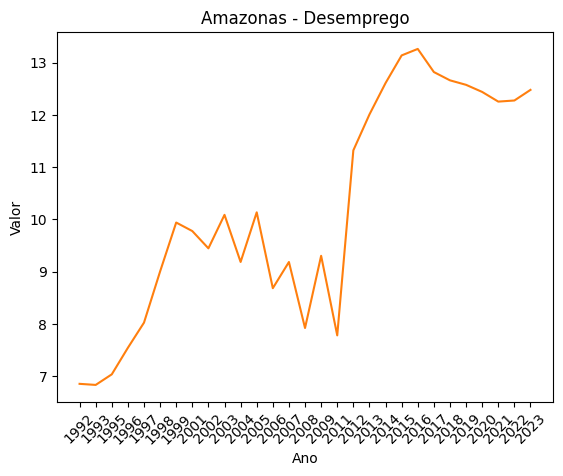

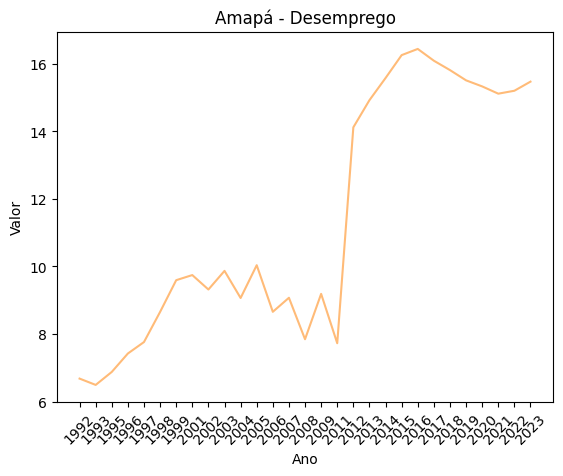

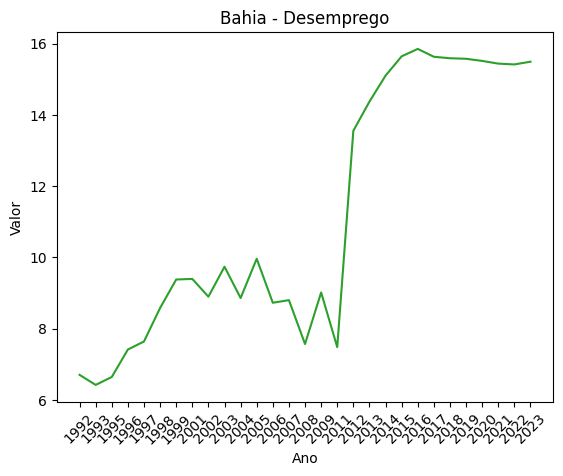

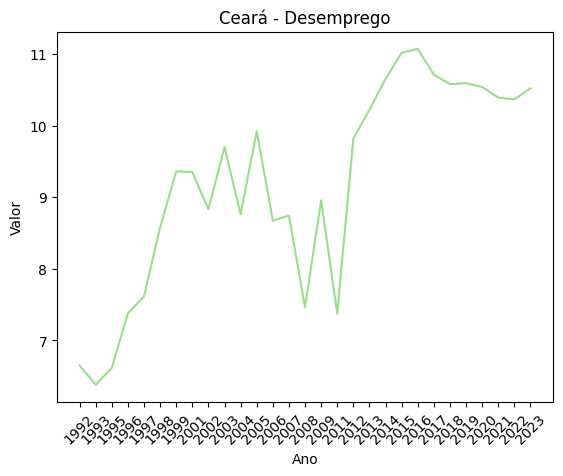

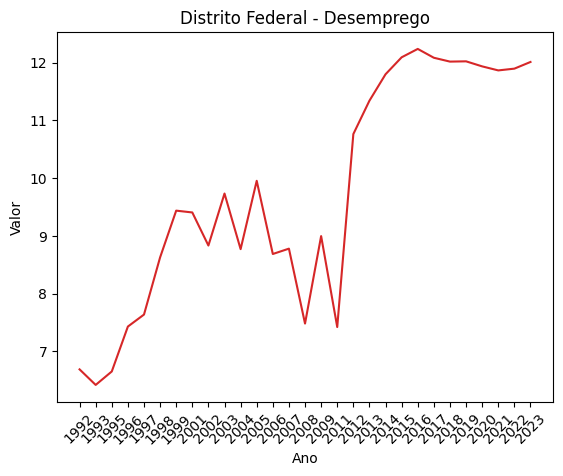

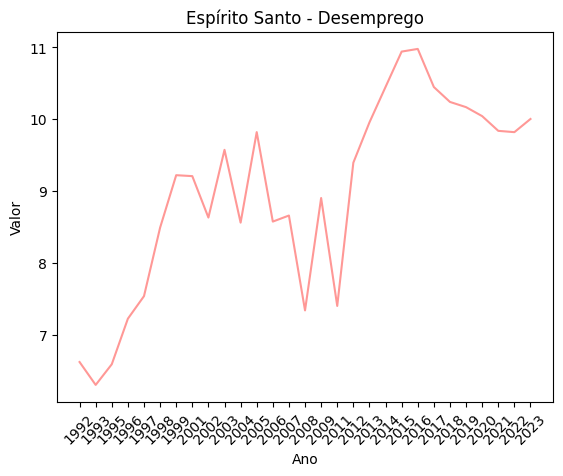

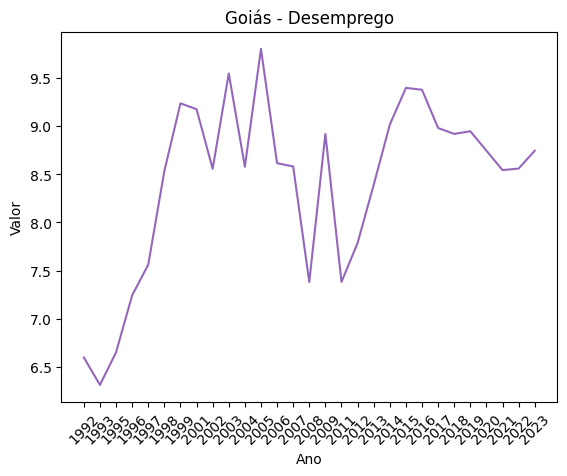

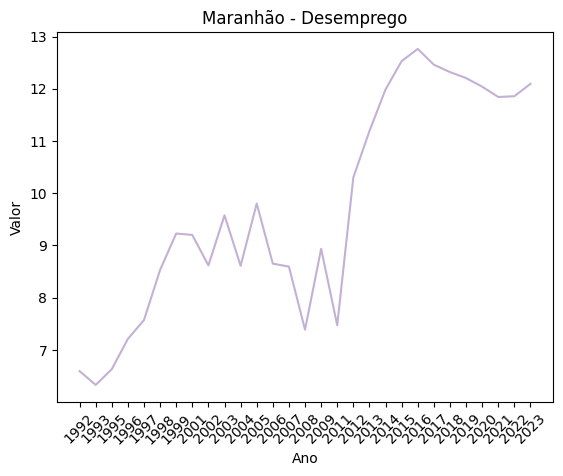

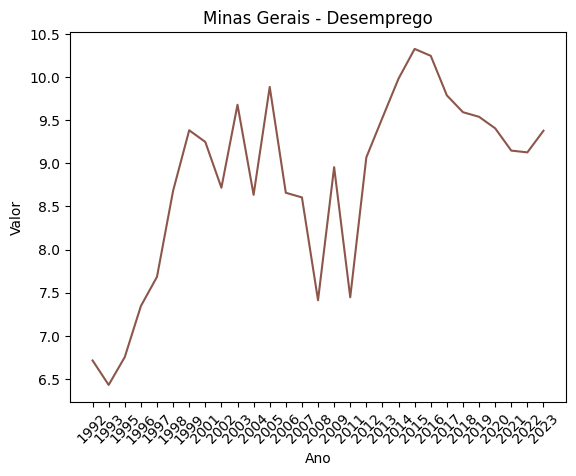

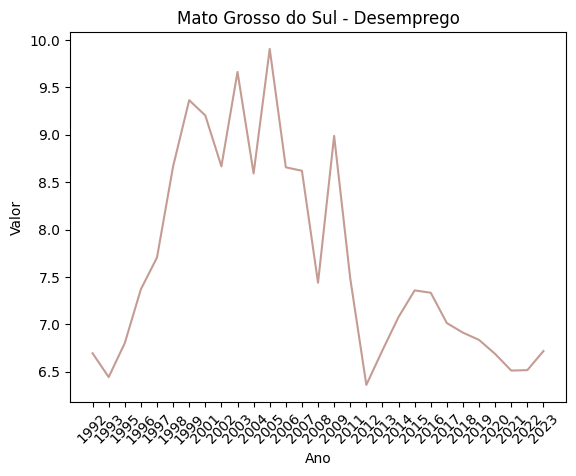

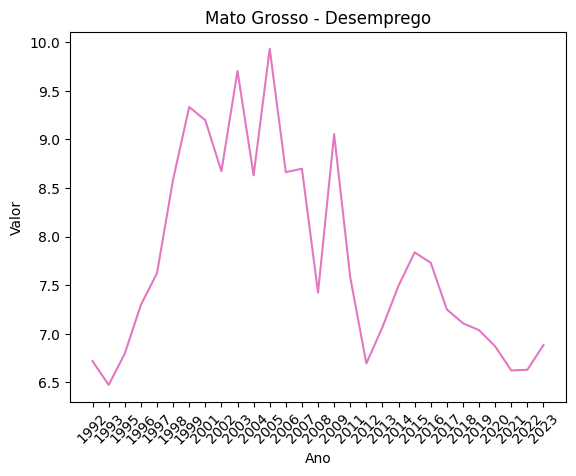

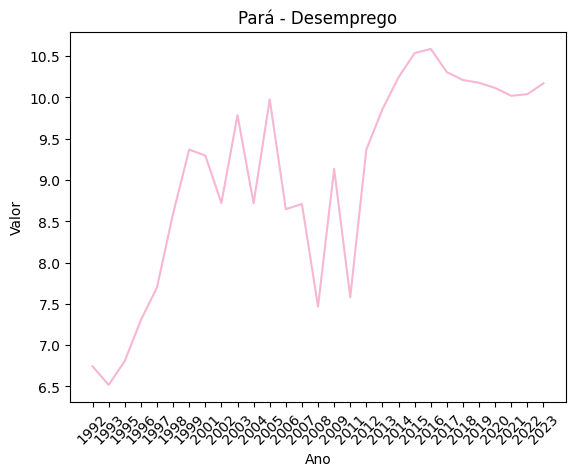

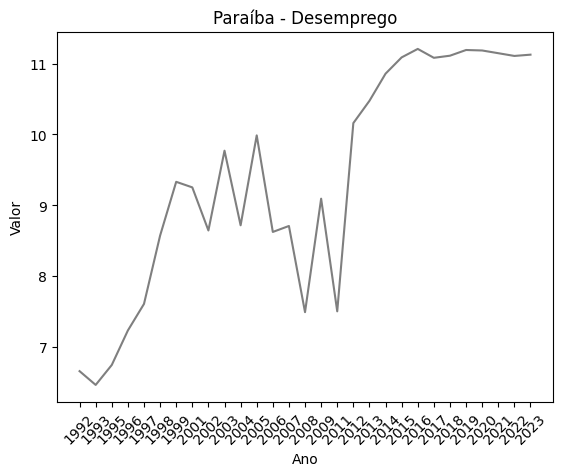

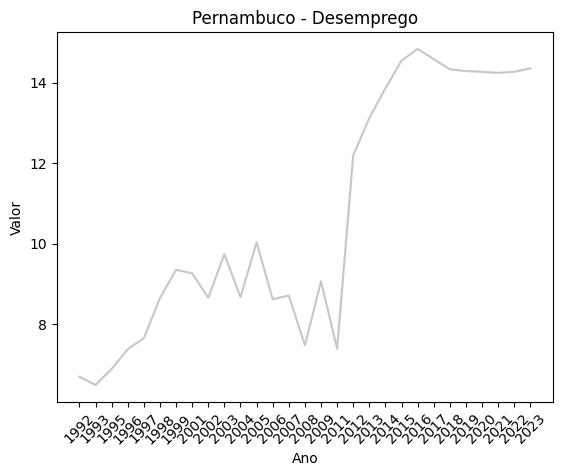

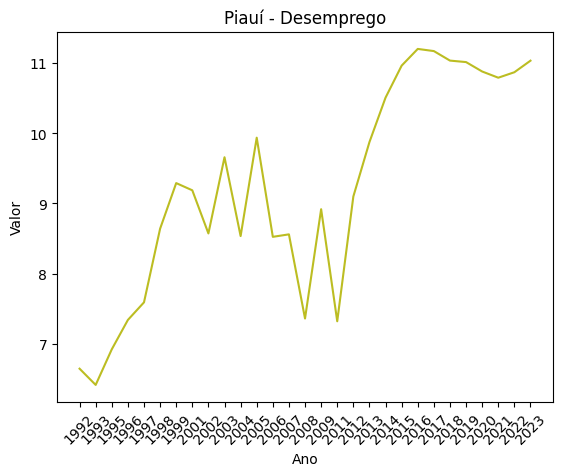

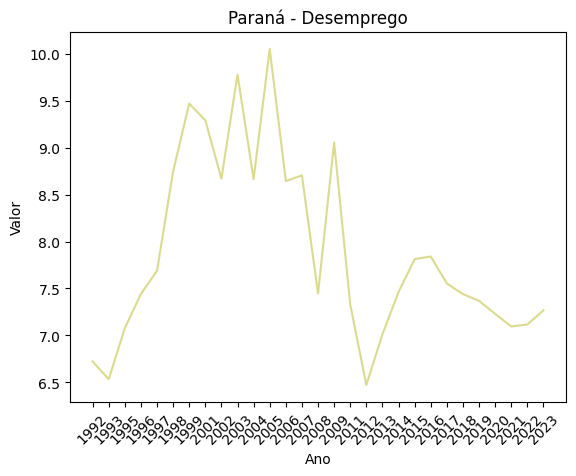

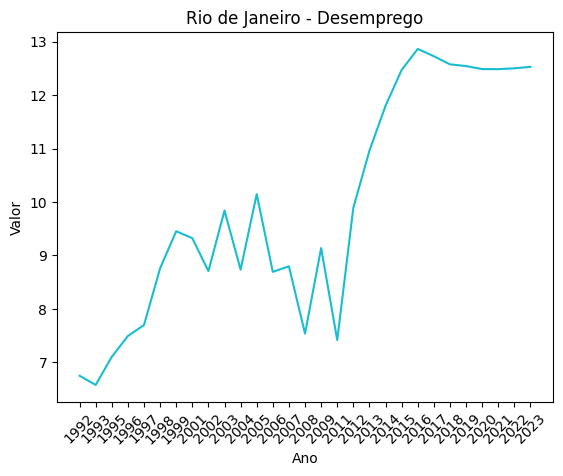

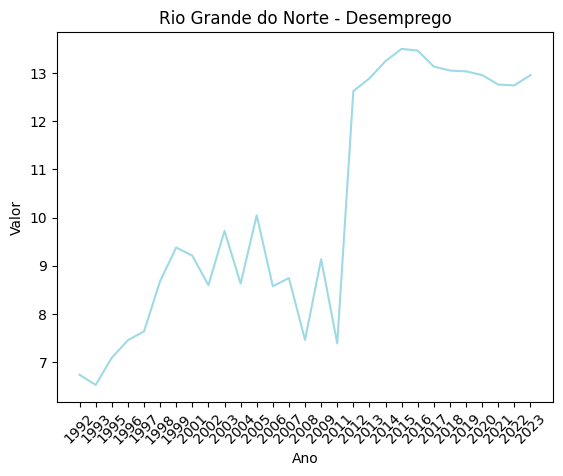

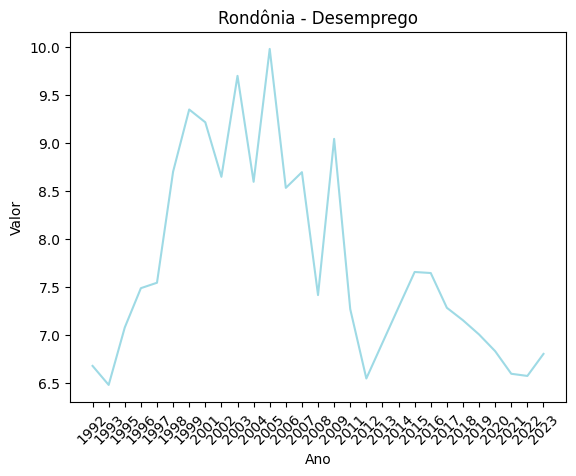

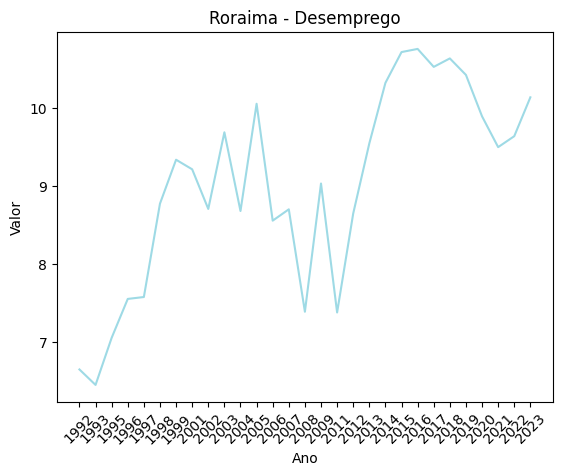

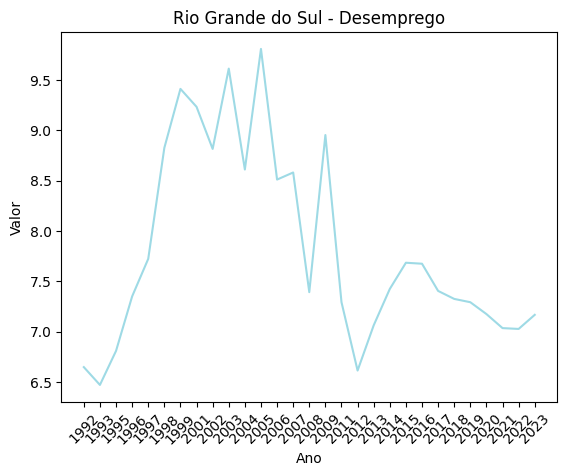

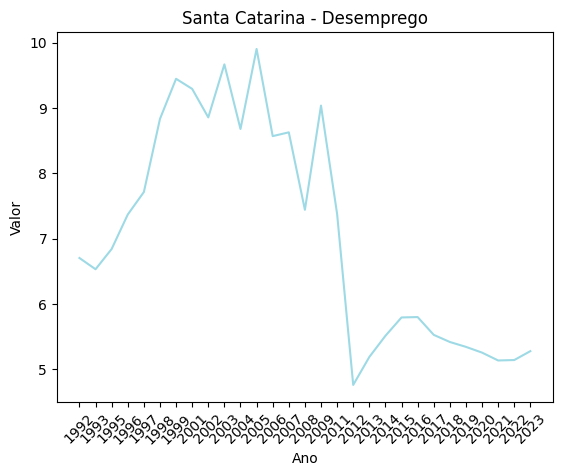

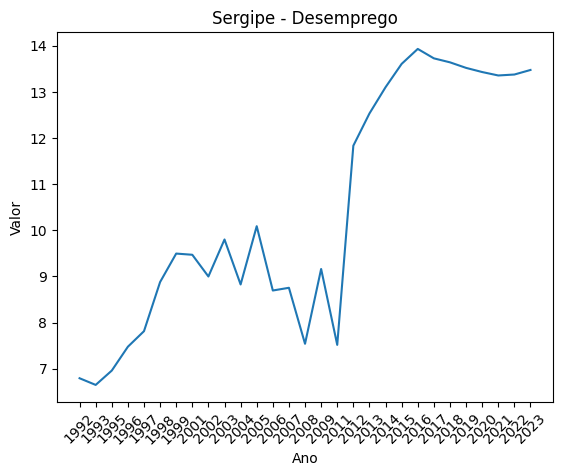

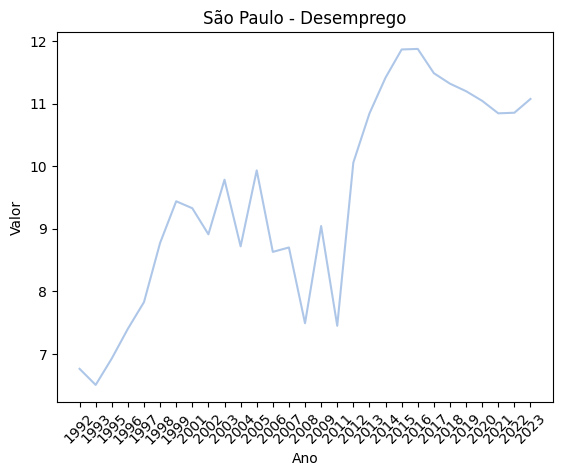

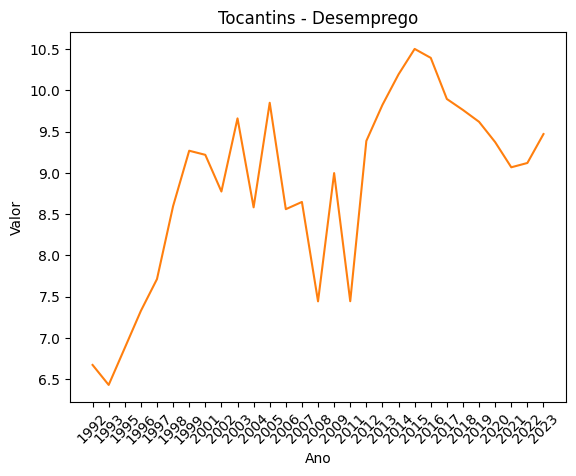

In [13]:
plot_columns(df_appended)

In [14]:
df_appended.index = df_appended.index.astype(int)
df_2014 = df_appended[df_appended.index >= 2014]
df_2014 = df_2014[df_2014.index < 2023]
df_2014

,Acre - Desemprego,Alagoas - Desemprego,Amazonas - Desemprego,Amapá - Desemprego,Bahia - Desemprego,Ceará - Desemprego,Distrito Federal - Desemprego,Espírito Santo - Desemprego,Goiás - Desemprego,Maranhão - Desemprego,...,Paraná - Desemprego,Rio de Janeiro - Desemprego,Rio Grande do Norte - Desemprego,Rondônia - Desemprego,Roraima - Desemprego,Rio Grande do Sul - Desemprego,Santa Catarina - Desemprego,Sergipe - Desemprego,São Paulo - Desemprego,Tocantins - Desemprego
Ano,,,,,,,,,,,,,,,,,,,,,
2014,11.666939,14.169213,12.610217,15.577783,15.102184,10.652422,11.799788,10.450155,9.015756,11.986521,...,7.462443,11.800434,13.2513,7.28726,10.3283,7.423718,5.511795,13.099831,11.4158,10.192991
2015,12.13967,14.659464,13.139356,16.255907,15.644545,11.020421,12.093705,10.942052,9.398111,12.529442,...,7.813261,12.471375,13.501882,7.654493,10.723767,7.683986,5.792915,13.605605,11.865646,10.50109
2016,12.458072,14.776623,13.263561,16.439693,15.852241,11.073199,12.23879,10.979229,9.37845,12.762358,...,7.840669,12.865739,13.466118,7.643673,10.764101,7.674279,5.798844,13.929548,11.874466,10.39274
2017,12.24579,14.347557,12.821072,16.090418,15.631769,10.712887,12.085632,10.448735,8.980786,12.460135,...,7.5531,12.728617,13.134883,7.282097,10.533542,7.404242,5.526597,13.725374,11.486716,9.894472
2018,12.148886,14.104975,12.662274,15.812868,15.590819,10.581166,12.018938,10.241458,8.919908,12.318837,...,7.440077,12.577126,13.052784,7.152179,10.642202,7.324869,5.417481,13.638962,11.319293,9.761228
2019,12.045733,13.904156,12.576164,15.509234,15.575601,10.594941,12.023662,10.168769,8.947167,12.204421,...,7.36847,12.544345,13.035247,7.004255,10.430272,7.291978,5.342752,13.518614,11.198876,9.617662
2020,11.905311,13.726047,12.440277,15.329624,15.515507,10.540017,11.936222,10.043678,8.74541,12.0393,...,7.229325,12.488461,12.958312,6.830604,9.898626,7.174483,5.254689,13.428525,11.044481,9.371493
2021,11.817334,13.450561,12.255143,15.114537,15.439822,10.393445,11.866376,9.839045,8.543845,11.842073,...,7.094891,12.486894,12.76146,6.595528,9.503368,7.034975,5.134381,13.354176,10.845149,9.066728
2022,11.830301,13.470373,12.276323,15.201106,15.416984,10.367164,11.896987,9.820791,8.559723,11.856801,...,7.116836,12.50273,12.74496,6.573031,9.643865,7.02674,5.141006,13.374761,10.85438,9.118915


In [16]:
for column in df_2014.columns:
    file_name = f"2014_01_{column}.csv"
    column_df = df_2014[[column]]
    column_df.to_csv(file_name, index=True)